# Incidence of chickenpox-like illness in France

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

The data on the incidence of chickenpox-like illness are available from the Web site of the [Réseau Sentinelles](http://www.sentiweb.fr/). We download them as a file in CSV format, in which each line corresponds to a week in the observation period. Only the complete dataset, starting in 1991 and ending with a recent week, is available for download.

In [2]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

This is the documentation of the data from [the download site](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):

| Column name  | Description                                                                                                               |
|--------------|---------------------------------------------------------------------------------------------------------------------------|
| `week`       | ISO8601 Yearweek number as numeric (year times 100 + week nubmer)                                                               |
| `indicator`  | Unique identifier of the indicator, see metadata document https://www.sentiweb.fr/meta.json                               |
| `inc`        | Estimated incidence value for the time step, in the geographic level                                                      |
| `inc_low`    | Lower bound of the estimated incidence 95% Confidence Interval                                                            |
| `inc_up`     | Upper bound of the estimated incidence 95% Confidence Interval                                                            |
| `inc100`     | Estimated rate incidence per 100,000 inhabitants                                                                          |
| `inc100_low` | Lower bound of the estimated incidence 95% Confidence Interval                                                            |
| `inc100_up`  | Upper bound of the estimated rate incidence 95% Confidence Interval                                                       |
| `geo_insee`  | Identifier of the geographic area, from INSEE https://www.insee.fr                                                        |
| `geo_name`   | Geographic label of the area, corresponding to INSEE code. This label is not an id and is only provided for human reading |

The first line of the CSV file is a comment, which we ignore with `skip=1`.

Check that the local file does not exist before downloading

In [3]:
import os
import urllib.request

data_file = "incidence-PAY-7.csv"

if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

In [4]:
raw_data = pd.read_csv(data_file, skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202328          7   8580     4331   12829      13           7   
1     202327          7   7393     4672   10114      11           7   
2     202326          7   9192     6223   12161      14          10   
3     202325          7  11498     8257   14739      17          12   
4     202324          7  11115     7968   14262      17          12   
5     202323          7  12563     6134   18992      19           9   
6     202322          7  12184     8125   16243      18          12   
7     202321          7  11349     7598   15100      17          11   
8     202320          7   9000     4615   13385      14           7   
9     202319          7   9344     6091   12597      14           9   
10    202318          7  10671     7291   14051      16          11   
11    202317          7   9184     6162   12206      14           9   
12    202316          7  11387     8014   14760      17          12   
13    202315          7  14040     7613   20467      21          11   
14    202314          7  15247    11032   19462      23          17   
15    202313          7  13322     9700   16944      20          15   
16    202312          7  10374     7218   13530      16          11   
17    202311          7   4919     2880    6958       7           4   
18    202310          7   4854     2731    6977       7           4   
19    202309          7   7004     4548    9460      11           7   
20    202308          7   8175     5316   11034      12           8   
21    202307          7   6595     3782    9408      10           6   
22    202306          7   9595     6017   13173      14           9   
23    202305          7   6237     3907    8567       9           5   
24    202304          7   6299     3973    8625       9           6   
25    202303          7   6063     3798    8328       9           6   
26    202302          7   6576     3060   10092      10           5   
27    202301          7   8153     5470   10836      12           8   
28    202252          7   5171     2717    7625       8           4   
29    202251          7   6226     3822    8630       9           5   
...      ...        ...    ...      ...     ...     ...         ...   
1672  199126          7  17608    11304   23912      31          20   
1673  199125          7  16169    10700   21638      28          18   
1674  199124          7  16171    10071   22271      28          17   
1675  199123          7  11947     7671   16223      21          13   
1676  199122          7  15452     9953   20951      27          17   
1677  199121          7  14903     8975   20831      26          16   
1678  199120          7  19053    12742   25364      34          23   
1679  199119          7  16739    11246   22232      29          19   
1680  199118          7  21385    13882   28888      38          25   
1681  199117          7  13462     8877   18047      24          16   
1682  199116          7  14857    10068   19646      26          18   
1683  199115          7  13975     9781   18169      25          18   
1684  199114          7  12265     7684   16846      22          14   
1685  199113          7   9567     6041   13093      17          11   
1686  199112          7  10864     7331   14397      19          13   
1687  199111          7  15574    11184   19964      27          19   
1688  199110          7  16643    11372   21914      29          20   
1689  199109          7  13741     8780   18702      24          15   
1690  199108          7  13289     8813   17765      23          15   
1691  199107          7  12337     8077   16597      22          15   
1692  199106          7  10877     7013   14741      19          12   
1693  199105          7  10442     6544   14340      18          11   
1694  199104          7   7913     4563   11263      14           8   
1695  199103          7  15387    10484   20290      27          18   
1696  199102          7  16277  

Are there missing data points?

In [5]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

No, there's not

The dataset uses an uncommon encoding; the week number is attached
to the year number, leaving the impression of a six-digit integer.
That is how Pandas interprets it.

A second problem is that Pandas does not know about week numbers.
It needs to be given the dates of the beginning and end of the week.
We use the library `isoweek` for that.

Since the conversion is a bit lengthy, we write a small Python 
function for doing it. Then we apply it to all points in our dataset. 
The results go into a new column 'period'.

In [8]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data = raw_data
data['period'] = [convert_week(yw) for yw in data['week']]

There are two more small changes to make.

First, we define the observation periods as the new index of
our dataset. That turns it into a time series, which will be
convenient later on.

Second, we sort the points chronologically.

In [9]:
sorted_data = data.set_index('period').sort_index()

We check the consistency of the data. Between the end of a period and the beginning of the next one, the difference should be zero, or very small. We tolerate an error of one second.

In [10]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

The data is OK

A first look at the data!

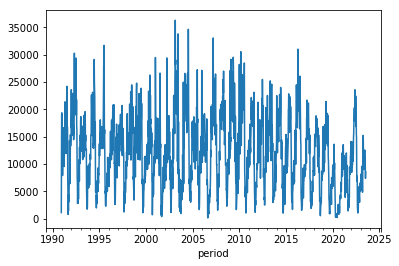

In [11]:
sorted_data['inc'].plot()

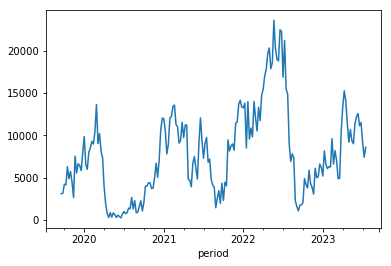

In [12]:
sorted_data['inc'][-200:].plot()

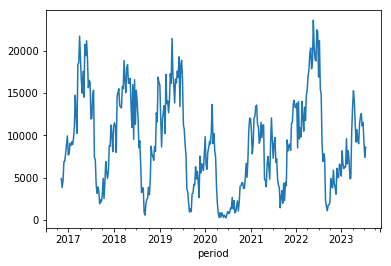

In [16]:
sorted_data['inc'][-350:].plot()

## Study of the annual incidence

In [19]:
first_august_week = [pd.Period(pd.Timestamp(y, 8, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

In [21]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1],
                        first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

And here are the annual incidences.

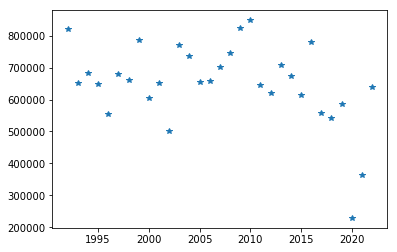

In [22]:
yearly_incidence.plot(style='*')

A sorted list makes it easier to find the highest values (at the end).

In [23]:
yearly_incidence.sort_values()

2020    229363
2021    363278
2002    502271
2018    543281
1996    553859
2017    557449
2019    584926
2000    605096
2015    613286
2012    620315
2022    638443
2011    645042
1995    648598
2001    650660
1993    653058
2005    654308
2006    657482
1998    660316
2014    673458
1997    679308
1994    682920
2007    701566
2013    708874
2004    736266
2008    745701
2003    770211
2016    780645
1999    784963
1992    821558
2009    822819
2010    848236
dtype: int64

In [24]:
first_august_week = [pd.Period(pd.Timestamp(y, 8, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

In [25]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1],
                        first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

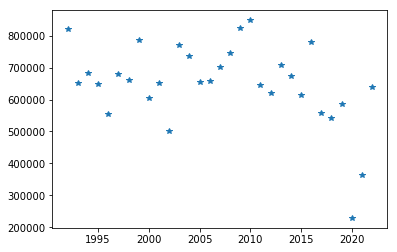

In [26]:
yearly_incidence.plot(style='*')

In [27]:
 yearly_incidence.sort_values()

2020    229363
2021    363278
2002    502271
2018    543281
1996    553859
2017    557449
2019    584926
2000    605096
2015    613286
2012    620315
2022    638443
2011    645042
1995    648598
2001    650660
1993    653058
2005    654308
2006    657482
1998    660316
2014    673458
1997    679308
1994    682920
2007    701566
2013    708874
2004    736266
2008    745701
2003    770211
2016    780645
1999    784963
1992    821558
2009    822819
2010    848236
dtype: int64

In [29]:
first_august_week = [pd.Period(pd.Timestamp(y, 8, 1), 'W')
                     for y in range(1990,
                                    sorted_data.index[-1].year)]

In [30]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1],
                        first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

AssertionError: 

2020    229363
2021    363278
2002    502271
2018    543281
1996    553859
2017    557449
2019    584926
2000    605096
2015    613286
2012    620315
2022    638443
2011    645042
1995    648598
2001    650660
1993    653058
2005    654308
2006    657482
1998    660316
2014    673458
1997    679308
1994    682920
2007    701566
2013    708874
2004    736266
2008    745701
2003    770211
2016    780645
1999    784963
2009    822819
2010    848236
dtype: int64

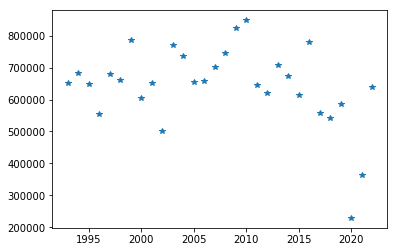

In [31]:
first_august_week = [pd.Period(pd.Timestamp(y, 8, 1), 'W')
                     for y in range(1992,
                                    sorted_data.index[-1].year)]

year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1],
                        first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)
yearly_incidence.plot(style='*')
yearly_incidence.sort_values()